# Recommendations with IBM

In this notebook, I will build out a number of different methods for making recommendations that can be used for different situations. Real data from the IBM Watson Studio platform will be used.

The project rubric can be found [here](https://review.udacity.com/#!/rubrics/3325/view).

## Table of Contents

I.  [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III.[User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V.  [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Conclusion](#conclusions)

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import project_tests as t
import pickle

%matplotlib inline

In [2]:
# Loading in data
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [3]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


Columns include:
- article_id
- title
- email

In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


Columns include:
- doc_body
- doc_description
- doc_full_name
- doc_status
- article_id 

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

#### What is the distribution of how many articles a user interacts with in the dataset?

In [5]:
df.shape, df_content.shape

((45993, 3), (1056, 5))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [7]:
df.describe()

,article_id
count,45993.000000
mean,908.846477
std,486.647866
min,0.000000
25%,460.000000
50%,1151.000000
75%,1336.000000
max,1444.000000


In [8]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


In [9]:
df_content.describe()

,article_id
count,1056.000000
mean,523.913826
std,303.480641
min,0.000000
25%,260.750000
50%,523.500000
75%,786.250000
max,1050.000000


In [10]:
# The median and maximum number of user_article interactios below:

# 50% of individuals interact with 3 number of articles or fewer
median_val = df.groupby('email')['article_id'].count().median()

# The maximum number of user-article interactions by any (1) user is 364.
max_views_by_user = df.groupby('email')['article_id'].count().max()

print("The median number of articles that individuals interact with is", median_val)
print("The maximum number of articles interacted by a user is", max_views_by_user)

The median number of articles that individuals interact with is 3.0
The maximum number of articles interacted by a user is 364


In [11]:
user_interact = df.groupby('email')['article_id'].count()
user_interact.describe() # Matches with above

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

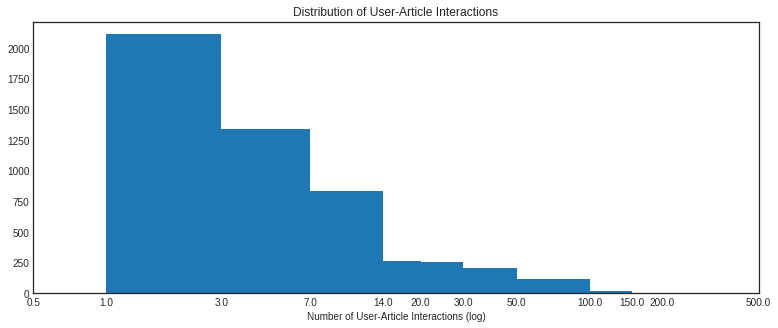

In [12]:
# Distribution plot of the interactions
hist_bins = [0,1,3,7,14,20,30,50,100,150,200]
hist_ticks = np.array([0.5, 1,3,7,14,20,30,50,100,150,200,500])

plt.figure(figsize=(13,5))
plt.style.use("seaborn-white")
plt.hist(x=user_interact, bins=hist_bins);

plt.xscale('log')
plt.xticks(hist_ticks, hist_ticks.astype(str))

plt.title('Distribution of User-Article Interactions');
plt.xlabel('Number of User-Article Interactions (log)');

#### Removing duplicate articles from the *df_content* dataframe.

In [13]:
# Find and explore duplicate rows
df_content.duplicated().sum()

0

In [14]:
# Only live in this column
df_content.doc_status.value_counts()

Live    1056
Name: doc_status, dtype: int64

In [15]:
# Some doc_body rows seem to be incorrect
# df_content.doc_body.value_counts().reset_index()

In [16]:
# Remove any rows that have the same article_id - only keep the first
df_content.article_id.duplicated().sum() #5 duplicates spotted
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)

In [17]:
df_content.article_id.duplicated().sum()

0

#### General Analysis

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [18]:
df.tail()

,article_id,title,email
45988,1324.0,ibm watson facebook posts for 2015,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45989,142.0,neural networks for beginners: popular types a...,d21b998d7a4722310ceeaa3c6aaa181a36db2d73
45990,233.0,bayesian nonparametric models – stats and bots,4faeed980a7cd11e0f3cf2058cc04daa2ef11452
45991,1160.0,analyze accident reports on amazon emr spark,abbf639ba05daa5249c520e290283a6d726ba78d
45992,16.0,higher-order logistic regression for large dat...,1f18e8aaccd6c8720180c3fe264c8aef5b00697f


In [19]:
# The number of unique articles that have at least one interaction
unique_articles = df.article_id.nunique()
unique_articles

714

In [20]:
df_content.tail()

,doc_body,doc_description,doc_full_name,doc_status,article_id
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049
1055,Homepage Follow Sign in / Sign up Homepage * H...,Once you get used to developing in a Notebook ...,"Jupyter Notebooks with Scala, Python, or R Ker...",Live,1050


In [21]:
# The number of unique articles on the IBM platform
total_articles = df_content.article_id.nunique()
total_articles

1051

In [22]:
# The number of unique users
unique_users = df.email.dropna().nunique()
unique_users

5148

In [23]:
# The number of user-article interactions
user_article_interactions = df.count()[0]
user_article_interactions

45993

#### The most viewed **article_id**, as well as how often it was viewed.

After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [24]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df.article_id.value_counts().index[0])

# The most viewed article in the dataset was viewed how many times?
max_views = df.article_id.value_counts().iloc[0]

most_viewed_article_id, max_views

('1429.0', 937)

In [25]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [26]:
## A spot check to see if the results are correct

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [27]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Sort by how often interacted 
    df_sorted = pd.DataFrame(df['article_id'].value_counts()\
                                             .sort_values(ascending=False))
    # Show top n and turn into list
    top_articles = list(df_sorted.index[:n])
    top_articles = df[df['article_id'].isin(top_articles)]['title'].unique()\
                                                                   .tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    df_sorted = pd.DataFrame(df['article_id'].value_counts()\
                                             .sort_values(ascending=False))
    top_articles = list(df_sorted.index.values[:n])
 
    return top_articles # Return the top article ids

In [28]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [29]:
# Test function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

top_5, top_10, top_20

(['use deep learning for image classification',
  'predicting churn with the spss random tree algorithm',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'insights from new york car accident reports'],
 ['healthcare python streaming application demo',
  'use deep learning for image classification',
  'apache spark lab, part 1: basic concepts',
  'predicting churn with the spss random tree algorithm',
  'analyze energy consumption in buildings',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'gosales transactions for logistic regression model',
  'insights from new york car accident reports',
  'finding optimal locations of new store using decision optimization'],
 ['healthcare python streaming application demo',
  'use deep learning for image classification',
  'classify tumors with machine learning',
  'apache spark lab, part 1: basic concepts',
  'the nurse assignment prob

In [30]:
# Test each of your the lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [31]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Unstack the user-item interaction df, fill in missing values with 0, convert to int
    user_item = df.drop_duplicates(subset=['article_id', 'user_id']).groupby(['user_id','article_id'])['title'].count().unstack(fill_value=0).astype('int')
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [32]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [33]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of similar users
    
    '''
    # compute similarity of each user to the provided user
    comp_sim = user_item.dot(np.transpose(user_item))
    
    # sort by similarity
    sort_sim = comp_sim[user_id].sort_values(ascending = False)
    
    # create list of just the ids
    most_similar_users = sort_sim.index.tolist()
    
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [34]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.columns.values[list(user_item.loc[user_id,] == 1)]
    article_ids = article_ids.astype(str)
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Store Recommendations
    recs = []
    # Users list of the article_ids and article titles that have been seen by a user
    viewed = get_user_articles(80) # Limit 80 to prevent list being too large
    # Return similar users
    similar_user_id = find_similar_users(80)
    
    # Create a list of recommendation using similar users
    for user in similar_user_id:
        article_ids, article_names = get_user_articles(user)
        recs = list(set().union(recs, article_ids)) 
        if len(recs) >= m:
            break
    
    recs = recs[:m]
    
    return recs # return your recommendations for this user_id    

In [35]:
# Check Results and return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10))

['using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'apache spark lab, part 1: basic concepts',
 'data science for real-time streaming analytics',
 'finding optimal locations of new store using decision optimization',
 'use r dataframes & ibm watson natural language understanding',
 'how to perform a logistic regression in r',
 'making data science a team sport',
 'a dynamic duo – inside machine learning – medium',
 'flightpredict ii: the sequel  – ibm watson data lab',
 'airbnb data for analytics: new york city reviews']

In [36]:
# Test functions to see if running correctly
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [37]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
                    1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df -  A Pandas dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Create neighbors dataframe
    neighbors_df = pd.DataFrame(columns=['neighbor_id', 'similarity', 'num_interactions'])
    
    # Populate the dataframe using loop
    for id in user_item.index.values:
        if id != user_id:
            neighbor_id = id
            
            # Equate similarity between users
            similarity = user_item[user_item.index == user_id].dot(user_item.loc[id].T).values[0]
            
            # Obtain number of interactions for user per article
            num_interactions = user_item.loc[id].values.sum()
            neighbors_df.loc[neighbor_id] = [neighbor_id, similarity, num_interactions]
    
    # Change column types into integers then change ascending order
    #neighbors_df['similarity'] = neighbors_df['similarity'].astype('int')
    #neighbors_df['neighbor_id'] = neighbors_df['neighbor_id'].astype('int')
    
    # Return the dataframe specified in the doc_string
    return neighbors_df.sort_values(by = ['similarity', 'neighbor_id'], ascending = [False, True])


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Recall get_top_sorted_users function to calculate similarities
    top_sorted_df = get_top_sorted_users(user_id, user_item=user_item)
    
    # User articles read
    user_article_ids, user_article_names = get_user_articles(user_id, user_item=user_item)
    
    # Create empty recommendations list
    recs = []
    
    # Creqte loop to create recommendations based on similar user (user 2)
    for user2 in top_sorted_df.neighbor_id:
        
        # Get User 2's article ids
        user2_article_ids, user2_article_names = get_user_articles(user2, user_item=user_item)
        
        # Iterate through each article read by user 2
        for user2_article_id in user2_article_ids:
            
            # If user 2's articles not in the articles read & not already in recommended
            if (user2_article_id not in user_article_ids) and (user2_article_id not in recs):
                
                # Then append to recs if n recs below threshold
                if len(recs) < m:
   
                    recs.append(str(user2_article_id))
                
                # Otherwise continue the iteration process
                else:
                    break

        # Break when m recommendations are reached
        if len(recs) == m:
            break
        
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [38]:
# Quick spot check to test the functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['43.0', '109.0', '111.0', '112.0', '164.0', '213.0', '225.0', '313.0', '337.0', '379.0']

The top 10 recommendations for user 20 are the following article names:
['deep learning with tensorflow course by big data university', 'learn tensorflow and deep learning together and now!', 'tidy up your jupyter notebooks with scripts', 'tensorflow quick tips', 'modeling energy usage in new york city', 'data structures related to machine learning algorithms', 'what is machine learning?', 'a visual explanation of the back propagation algorithm for neural networks', 'building custom machine learning algorithms with apache systemml', 'generalization in deep learning']


`5.` Testing the functions from above to correctly fill in the solutions to the dictionary below.
- Find the user that is most similar to user 1
- Find the 10th most similar user to user 131

In [39]:
user1_most_sim = get_top_sorted_users(1, df=df, user_item=user_item)['neighbor_id'].iloc[0]
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item)['neighbor_id'].iloc[9]

In [40]:
user1_most_sim, user131_10th_sim

(3933, 242)

In [41]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` Question: If given a new user, which of the above functions would be best to use to make recommendations?  Is there a better way to make recommendations?

It would be best to recommend using the 'get_top_article_ids' function. This is because this would allow a generallised recommendation using the population. The average user is likely to agree with these recommendations.

This is refered as the cold start. To tackle this a better approach would be to use content based recommendations. Perhaps to recommend from a selection of different topics: Economics, Entertainment, Global News, etc. A more commom method used is knowledge based recommendations. Here a new user when signing up could be prompted a series of questions which will personalise their recommendations.

`7.` What would be the top 10 recommended articles to provide for the a new user.

In [42]:
new_user = '0.0'

new_user_recs = get_top_article_ids(10)

new_user_recs

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  Possibly by considering content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.

For the scope of this project I will not be creating a function to do this. If I were to do this I would consider the most popular recommendations that meets the 'content criteria' that I would define.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, matrix factorization will be used to make article recommendations to the users on the IBM Watson Studio platform.

`1.` This first part will run the cells to get things set up for the rest of **Part V** of the notebook. 

In [43]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [44]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, Singular Value Decomposition can be used from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.

In [45]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # Using the built in to get the three matrices

In the Udacity lesson the method used fwas using the FunkSVD as the matrix was full of null values. In the lectures, user_item_matrix was created using user ratings, where some values were NaN. This matrix has two possible boolean values (no nulls). This ensures we can perform using numpy's SVD.

`3.` Question: How do we choose the number of latent features to use? 

By running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.

We get an idea of how the accuracy improves as we increase the number of latent features.

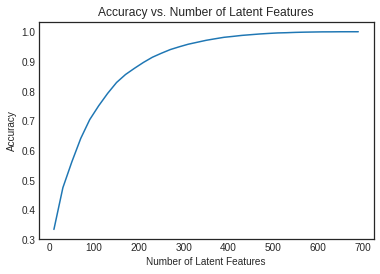

In [46]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # Restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # Take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # Compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # Sum total errors and append them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.

Question: Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features.
* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [47]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [48]:
test_idx # Length (Rows) = 682

Int64Index([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801,
            ...
            5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
           dtype='int64', name='user_id', length=682)

In [49]:
user_item_train.index # 4487 in training set

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487],
           dtype='int64', name='user_id', length=4487)

In [50]:
# Testing to see difference from the user-item matrix of the training dataframe
test_idx.difference(user_item_train.index)

# Length = 662 - missing values
# Difference is 20 from test_indx

Int64Index([4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4496, 4497,
            ...
            5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
           dtype='int64', name='user_id', length=662)

In [51]:
user_item_train.columns # 714 columns in train set

Float64Index([   0.0,    2.0,    4.0,    8.0,    9.0,   12.0,   14.0,   15.0,
                16.0,   18.0,
              ...
              1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0, 1441.0, 1442.0,
              1443.0, 1444.0],
             dtype='float64', name='article_id', length=714)

In [52]:
test_arts # 574 Rows in test column

Float64Index([   0.0,    2.0,    4.0,    8.0,    9.0,   12.0,   14.0,   15.0,
                16.0,   18.0,
              ...
              1432.0, 1433.0, 1434.0, 1435.0, 1436.0, 1437.0, 1439.0, 1440.0,
              1441.0, 1443.0],
             dtype='float64', name='article_id', length=574)

#### How many users can we make predictions for in the test set?

In [53]:
answer1 = user_item_train.index.isin(test_idx).sum()

print(f'We can make predictions for {answer1} users in the test dataset.')

We can make predictions for 20 users in the test dataset.


#### How many users are we not able to make predictions for because of the cold start problem?

In [54]:
answer2 = user_item_test.index.unique().size - answer1

print(f'We cannot make predictions for {answer2} users in the test dataset due to the cold start problem.')

We cannot make predictions for 662 users in the test dataset due to the cold start problem.


#### How many articles can we make predictions for in the test set?

In [55]:
answer3 = 574

print(f'We are able to make predictions for {answer3} articles.')

We are able to make predictions for 574 articles.


#### How many articles are we not able to make predictions for because of the cold start problem?

In [56]:
answer4 = len(np.setdiff1d(user_item_test.columns, user_item_train.columns))

print(f'We are NOT able to make predictions for {answer4} articles due to the cold start problem.')

We are NOT able to make predictions for 0 articles due to the cold start problem.


In [57]:
# Checking results
sol_4_dict = {
    'How many users can we make predictions for in the test set?': 20, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': 662, 
    'How many articles can we make predictions for in the test set?': 574,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': 0
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [58]:
# Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [59]:
print('train: ', u_train.shape, s_train.shape, vt_train.shape)

train:  (4487, 4487) (714,) (714, 714)


In [60]:
from sklearn.metrics import accuracy_score

# Rows that match the test set
test_idx = user_item_test.index
row_idxs = user_item_train.index.isin(test_idx)
u_test = u_train[row_idxs, :]

# Columns that match the test set
test_col = user_item_test.columns
col_idxs = user_item_train.columns.isin(test_col)
vt_test = vt_train[:, col_idxs]

# Test data
train_idx = user_item_train.index
row_idxs_2 = user_item_test.index.isin(train_idx)
sub_user_item_test = user_item_test.loc[row_idxs_2]

In [61]:
latent_feats = np.arange(10, 700+10, 20)

all_errs, train_errs, test_errs = [], [], []

# Loop through latent features
for k in latent_feats:
    # Restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # Take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(sub_user_item_test)))/(sub_user_item_test.shape[0]*sub_user_item_test.shape[1])))

    # Compute prediction accuracy
    train_errs.append(accuracy_score(user_item_train.values.flatten(), user_item_train_preds.flatten()))
    test_errs.append(accuracy_score(sub_user_item_test.values.flatten(), user_item_test_preds.flatten()))

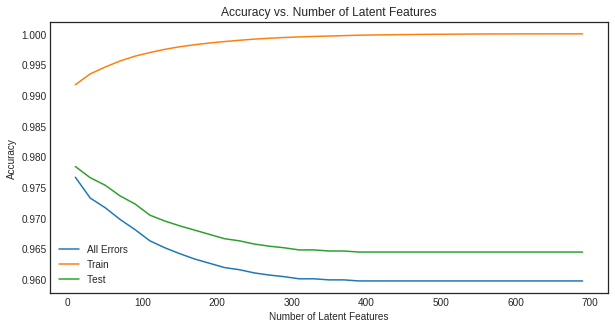

In [62]:
# Plot the accuracy vs number of features
plt.figure(figsize=(10,5))

plt.plot(latent_feats, all_errs, label='All Errors')
plt.plot(latent_feats, train_errs, label='Train')
plt.plot(latent_feats, test_errs, label='Test')

plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')

plt.legend(loc='best')
plt.show()

The accuracy appears to be quite high. This maybe due to biases. In the data, there are a lot more 0's than 1's.

`6.` Question: Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

These recommendations appear have a high accuracy for the users we can make recommendations for. However this could be due to the class imbalance in the data - a lot more 0's than 1's.

To determine if users like the recommendations we could perform an A/B tests. Randomly assigning half of users to a control group that receives no recommendations and a second group could be assigned recommendations using this engine. Then we can see if this these recommendations are an improvement on the existing process.

There were 662 users who we could not solve due to the cold start problem, 97% of users! To solve the cold-start problem, we can deploy a rank based or content based recommendation method.

<a id='conclusions'></a>
## Conclusion
Using this workbook, it can be now possible save recommendations for each user. By developing a class to make new predictions and update the results, then make a flask app to deploy the results.  These tasks are beyond what is required for this project.  However, from what I have learnt in the lessons, I am capable of taking these tasks on to improve upon my work here!

In [65]:
# Create a .html or .pdf version of this notebook in the workspace here. See the generated .html file in the workspace directory
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0